# Pruebas análisis de tendencia

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
from statsmodels.tsa.seasonal import STL

In [ ]:
NUM_SERIES_ESTUDIO = 3 # Número de series temporales más representarivas que queremos visualizar
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

In [3]:
with open("../procData/muestras_ovul_horas_norm1.pkl", "rb") as f:
    muestras_ovul = pickle.load(f)

In [4]:
muestras_tendencia = {}

for key, datos in muestras_ovul.items():
    df = datos["serie"].copy()
    
    df = df.sort_values("resultTimestamp").reset_index(drop=True)
    
    serie = df["result"]

    # Aplicar STL
    stl = STL(serie, period=24, robust=True)
    resultado = stl.fit()

    df["tendencia"] = resultado.trend

    muestras_tendencia[key] = {
        "serie": df,
        "ovul": datos["ovul"]
    }

In [5]:
# Guardar
with open("../procData/muestras_ovul_tend.pkl", "wb") as f:
    pickle.dump(muestras_tendencia, f)

In [6]:
tendencias = []

for datos in muestras_tendencia.values():
    tendencia = datos["serie"]["tendencia"].dropna().values
    tendencias.append(tendencia)

tendencias_array = np.array(tendencias)

In [7]:
media_tendencia = np.mean(tendencias_array, axis=0)
std_tendencia = np.std(tendencias_array, axis=0)

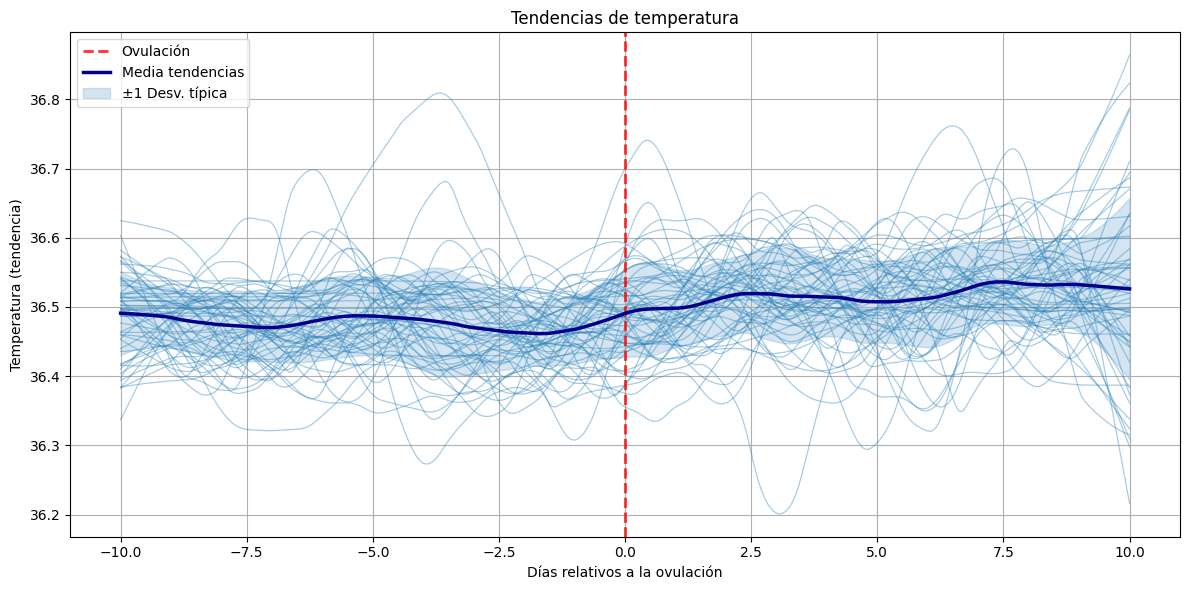

In [9]:
plt.figure(figsize=(12, 6))

# Dibujar todas las tendencias individuales alineadas por días relativos
for key, datos in muestras_tendencia.items():
    df = datos["serie"].copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)

    x = df["dias_rel"]
    y = df["tendencia"]
    plt.plot(x, y, color='#2980B9', alpha=0.4, linewidth=0.9)

# Línea vertical roja en el día 0 (ovulación)
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label="Ovulación", alpha=0.8)

# Para representar media y desviación típica:
# Aseguramos que todos los arrays de tendencia estén en el mismo eje relativo
tendencias_rel = []

for datos in muestras_tendencia.values():
    df = datos["serie"].copy()
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    df = df.set_index("dias_rel").sort_index()
    tendencias_rel.append(df["tendencia"])

# Combinar por índice (días relativos comunes)
df_tend_rel = pd.concat(tendencias_rel, axis=1, join="inner")
media_tend = df_tend_rel.mean(axis=1)
std_tend = df_tend_rel.std(axis=1)

# Dibujar media y desviación típica
plt.plot(media_tend.index, media_tend, color='darkblue', linewidth=2.5, label='Media tendencias')
plt.fill_between(media_tend.index,
                 media_tend - std_tend,
                 media_tend + std_tend,
                 color='#2980B9', alpha=0.2, label='±1 Desv. típica')

# Etiquetas y presentación
plt.title("Tendencias de temperatura")
plt.xlabel("Días relativos a la ovulación")
plt.ylabel("Temperatura (tendencia)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


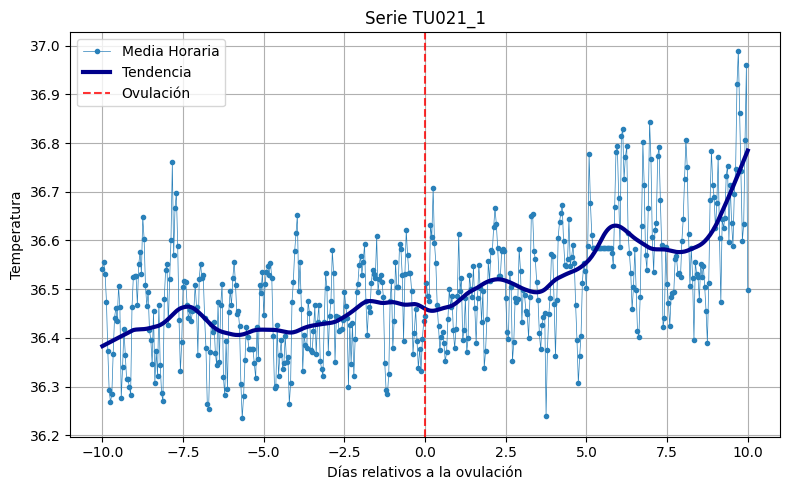

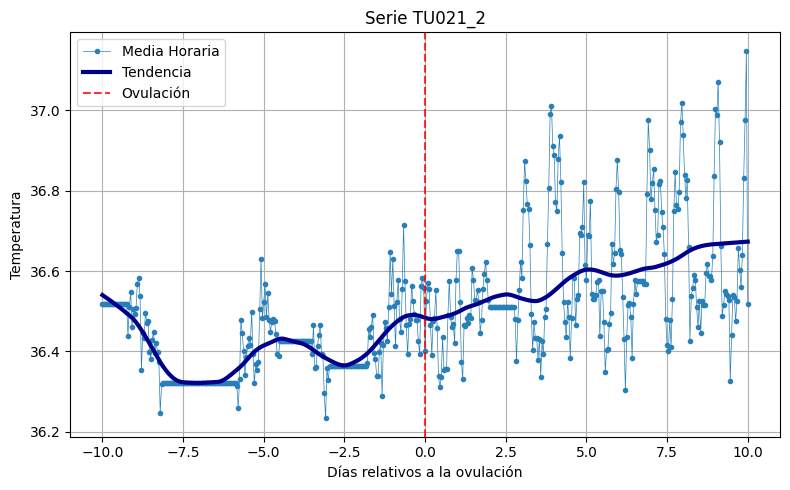

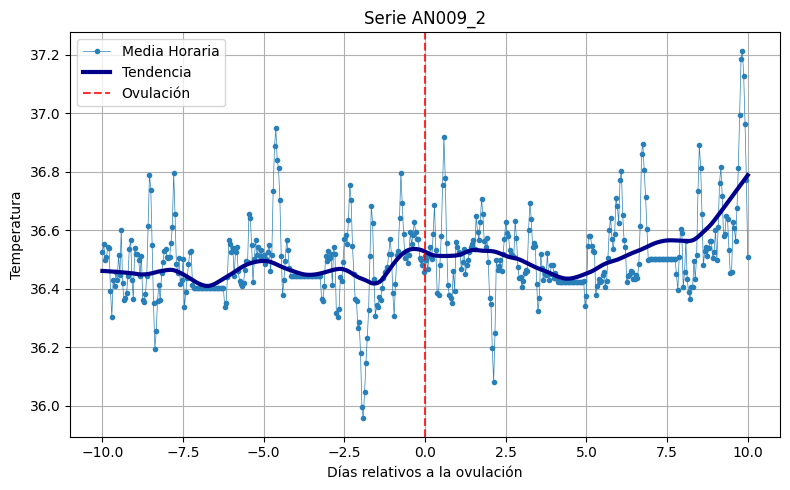

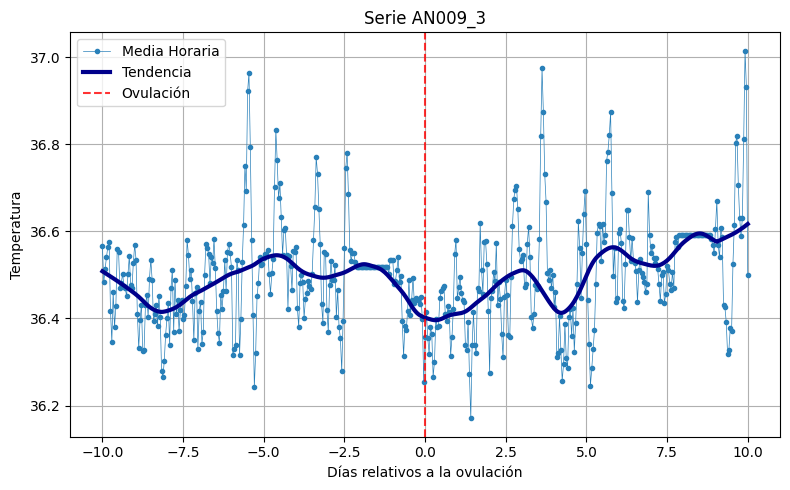

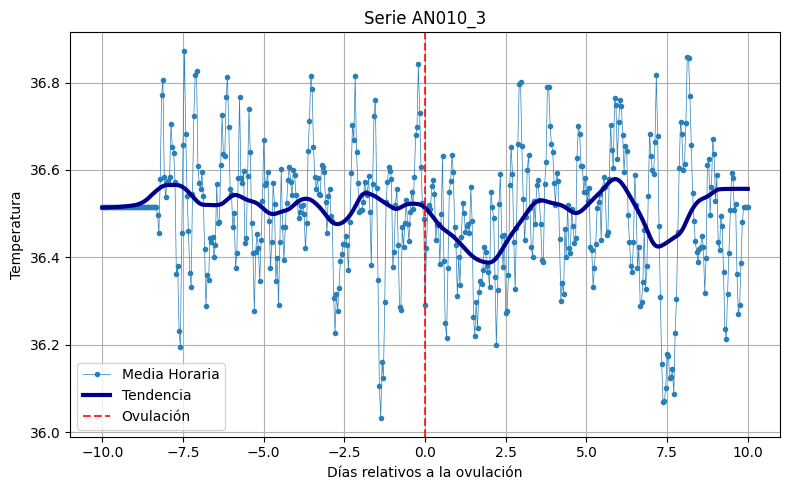

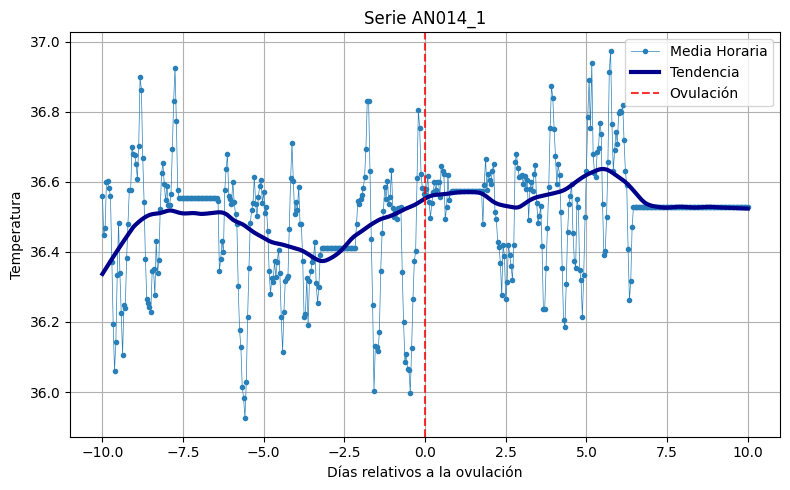

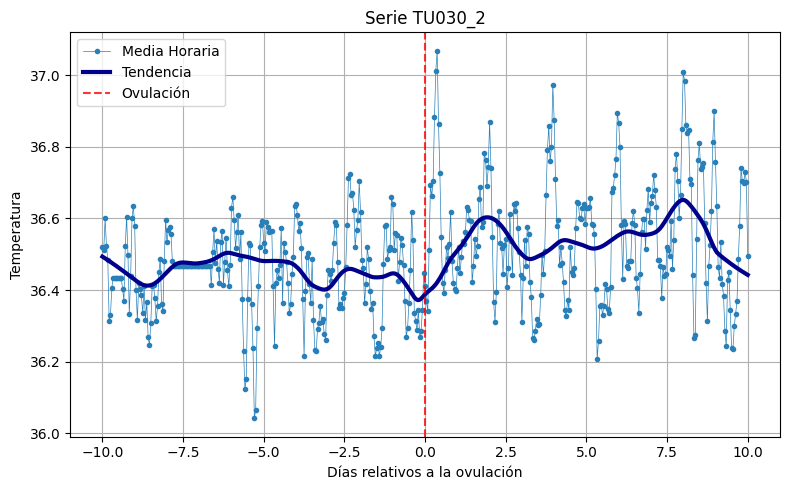

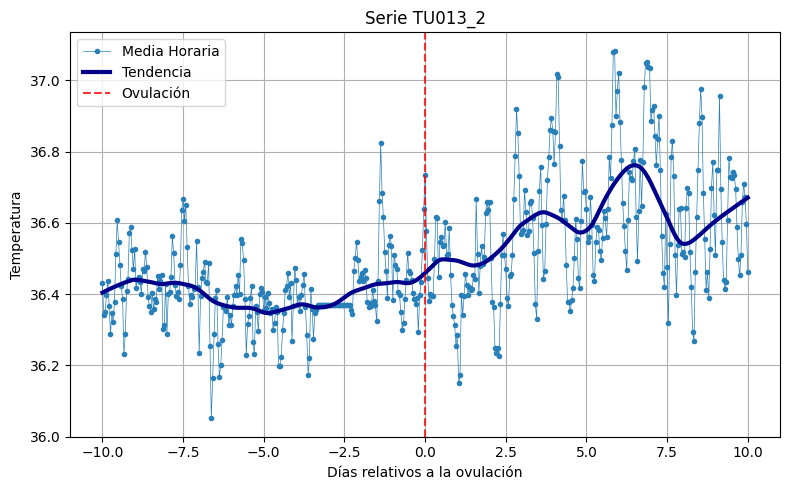

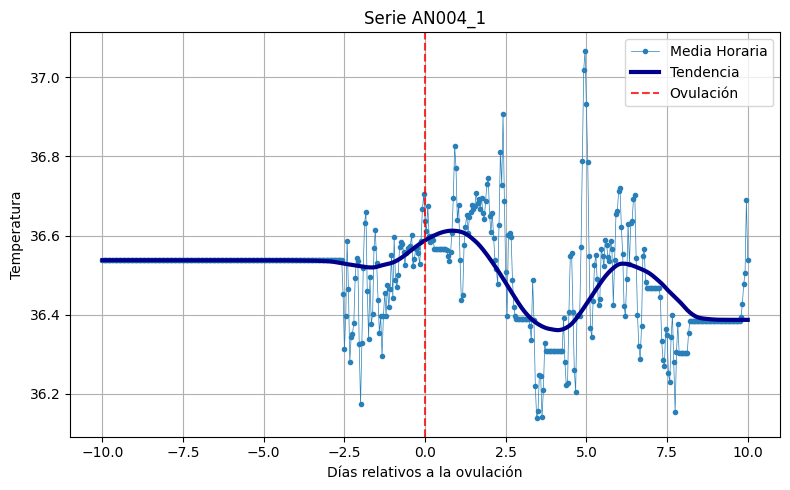

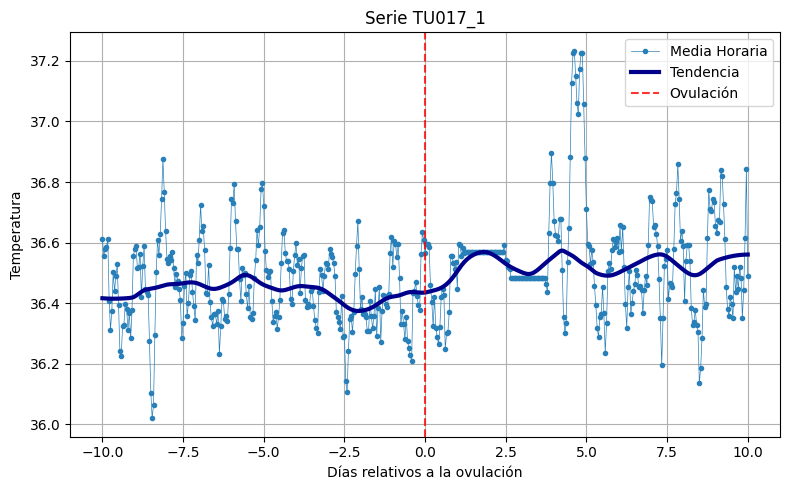

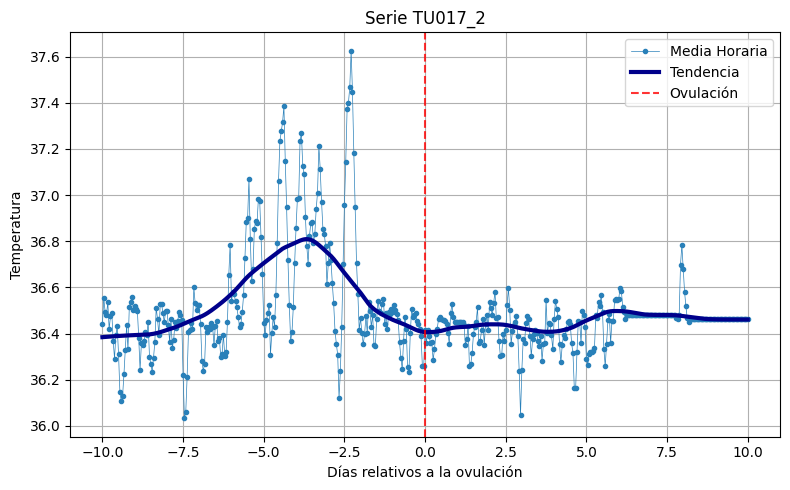

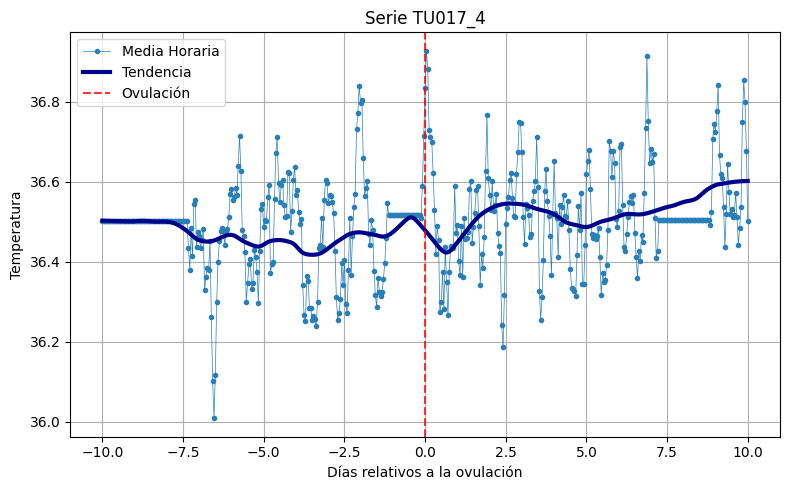

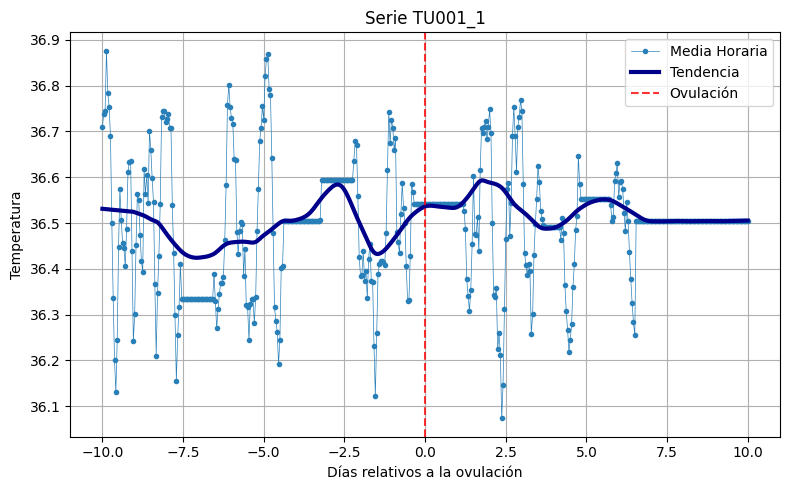

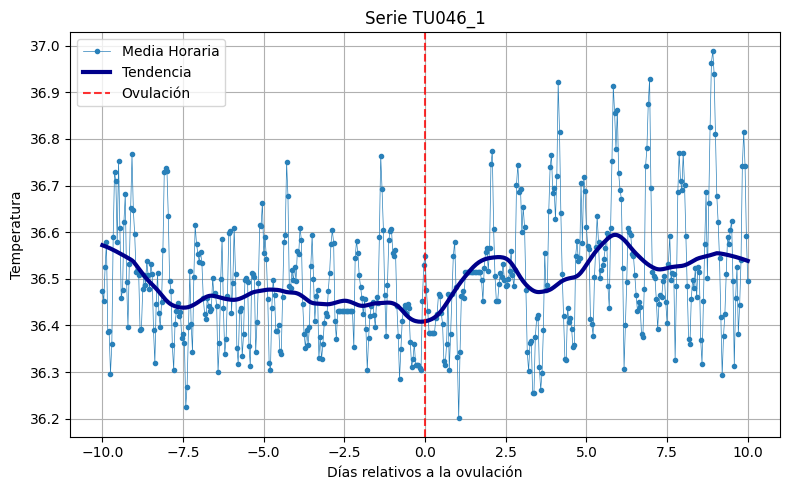

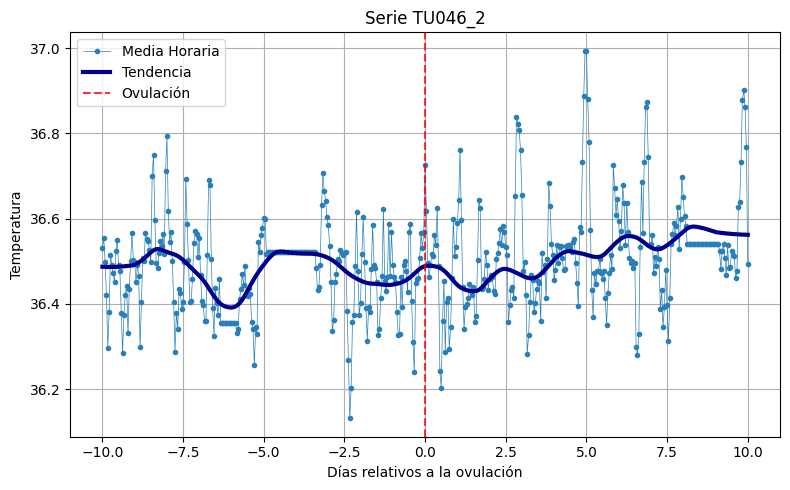

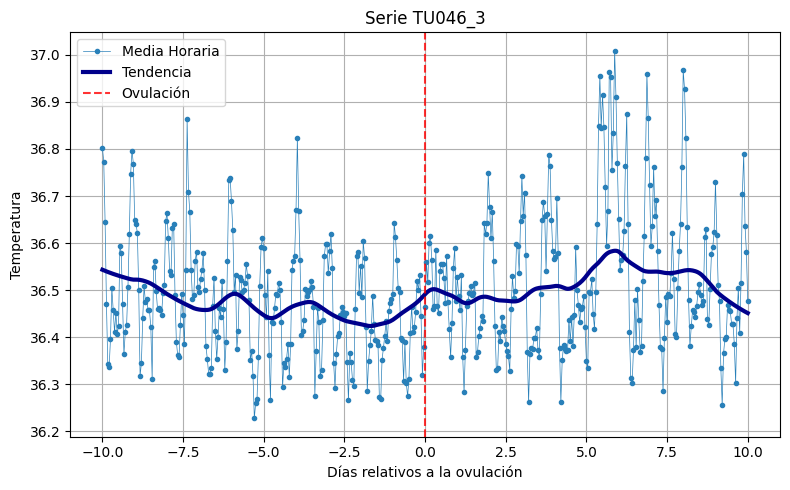

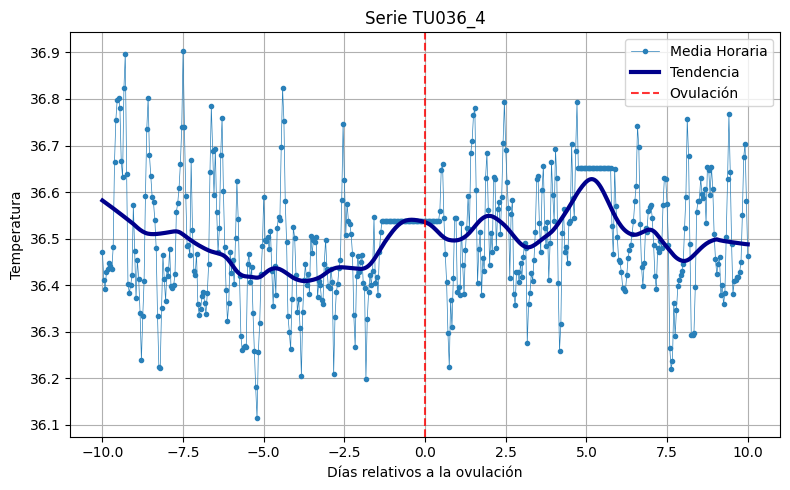

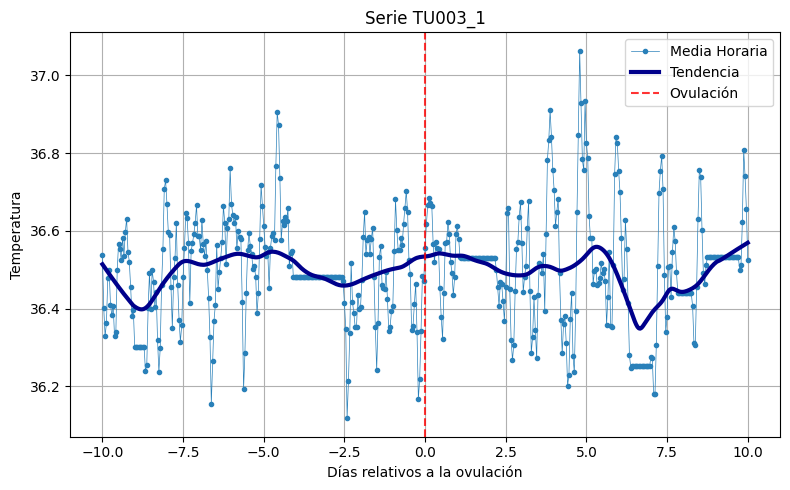

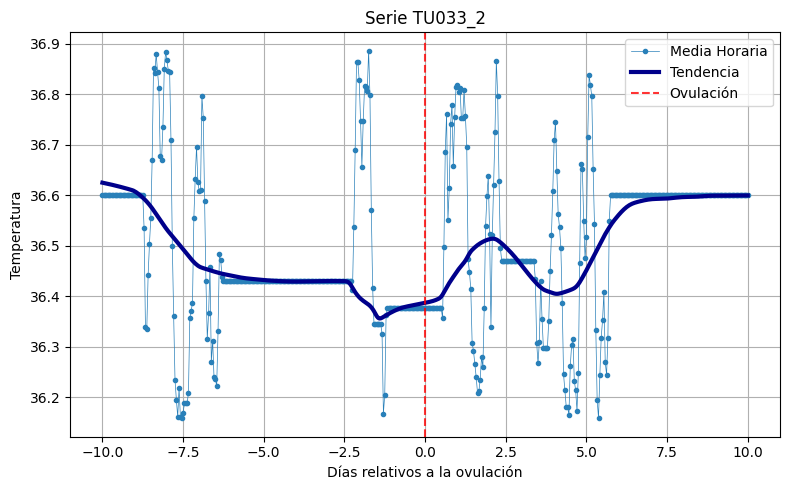

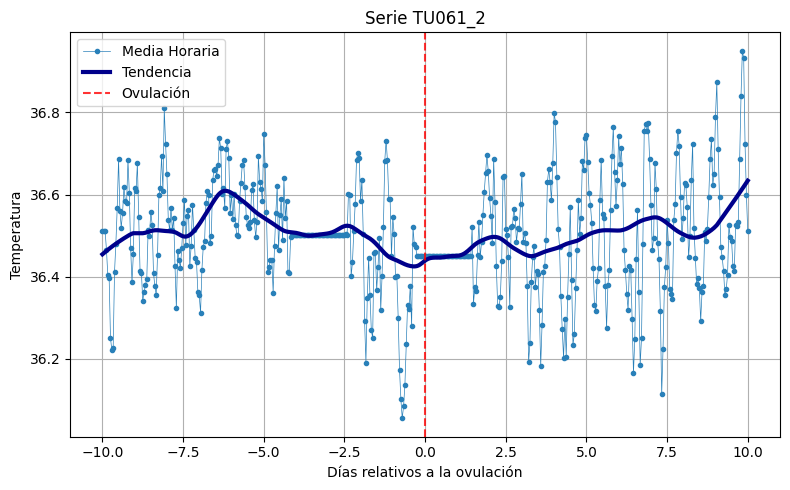

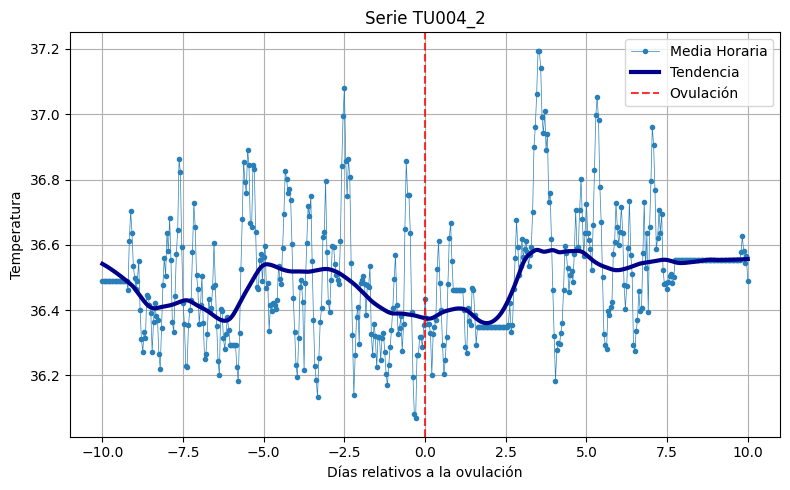

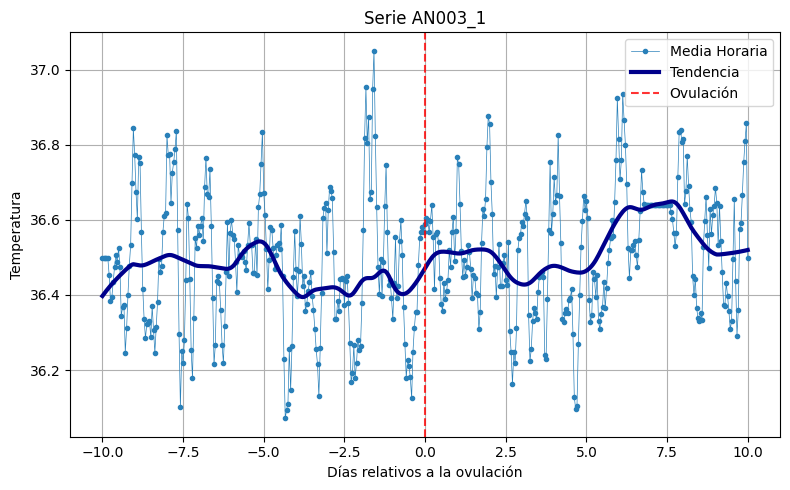

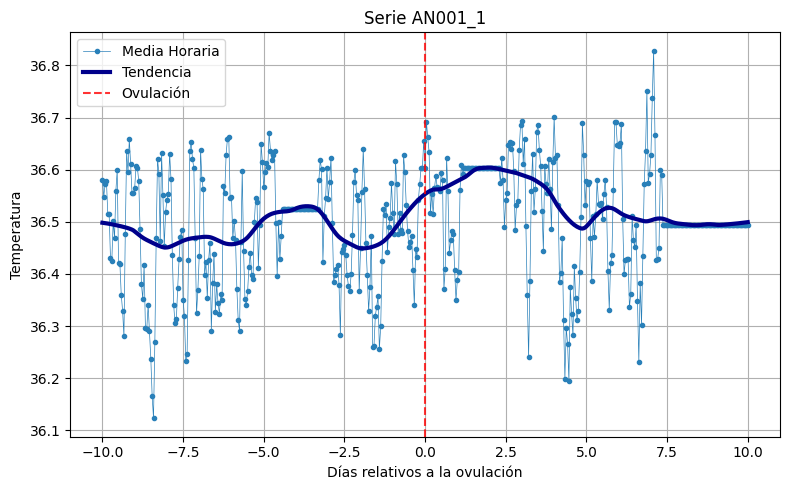

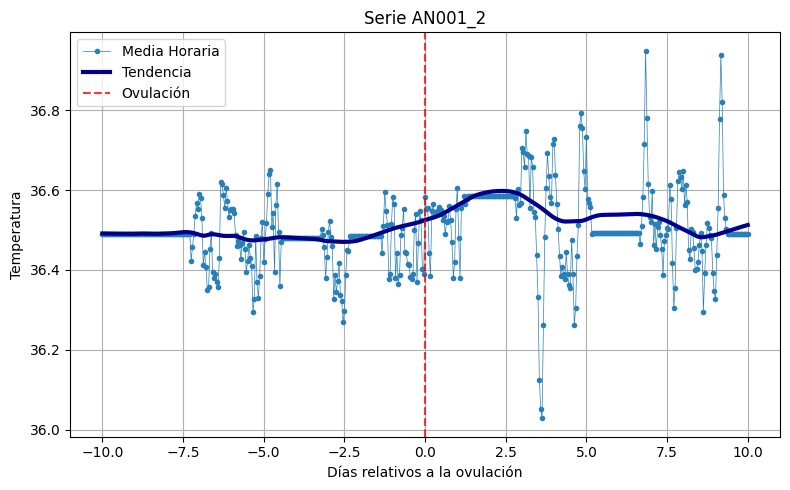

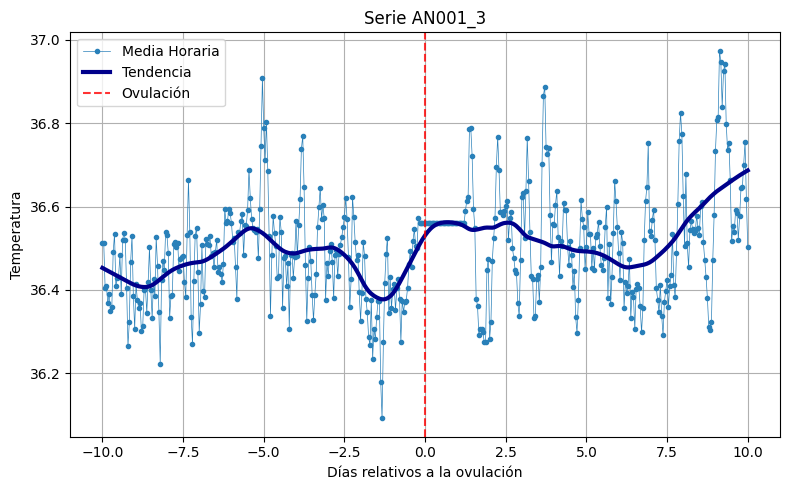

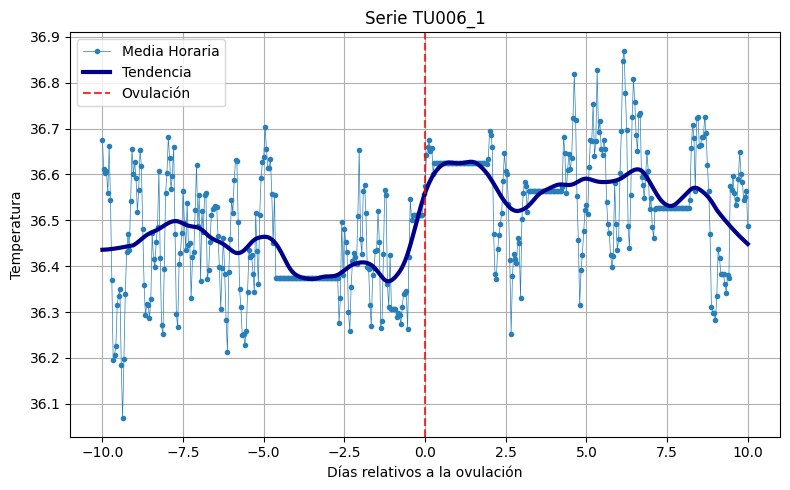

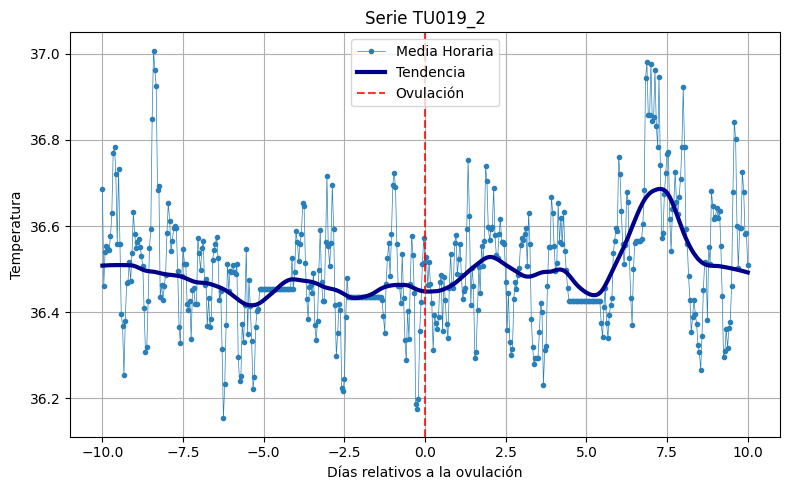

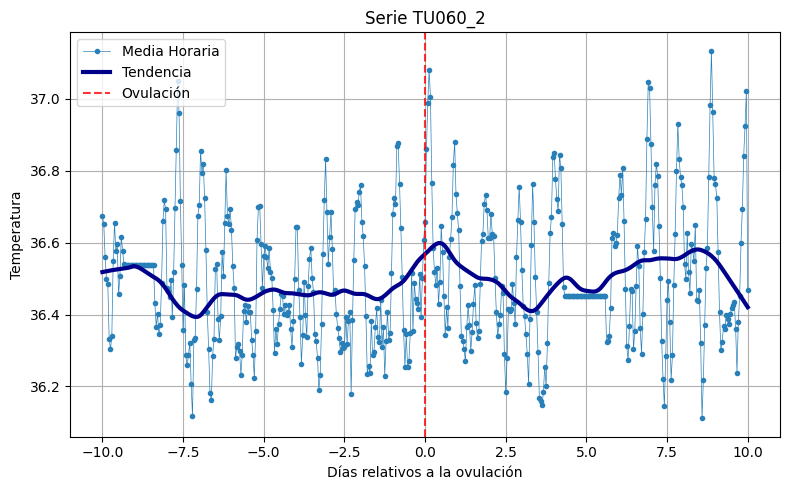

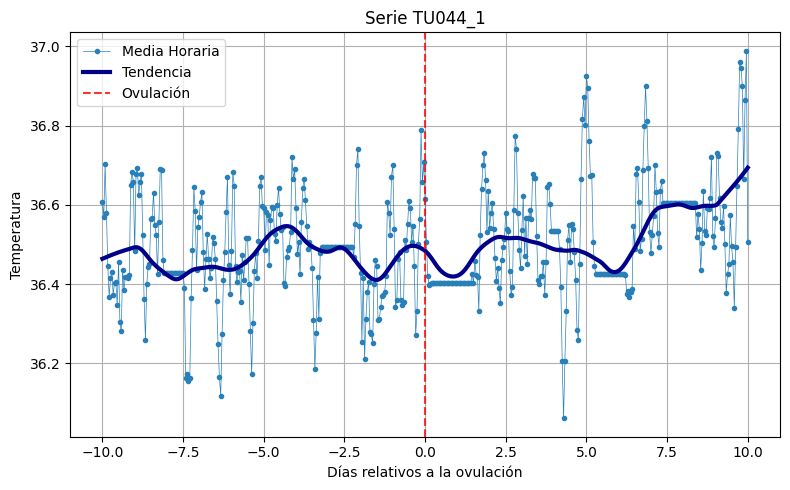

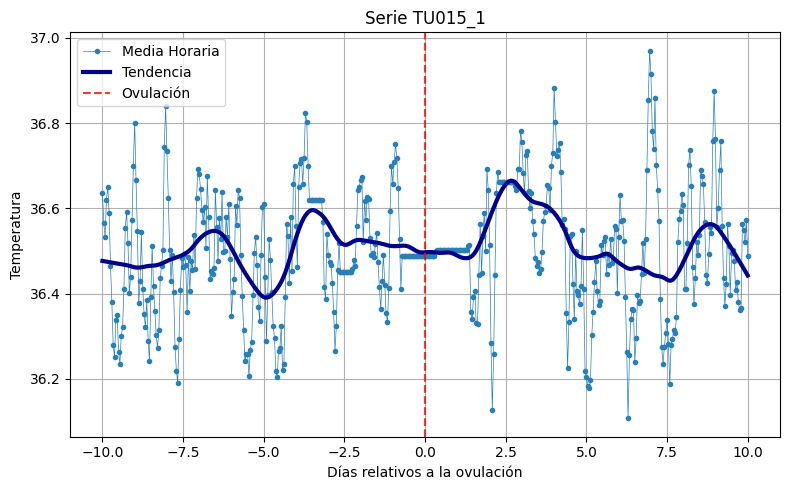

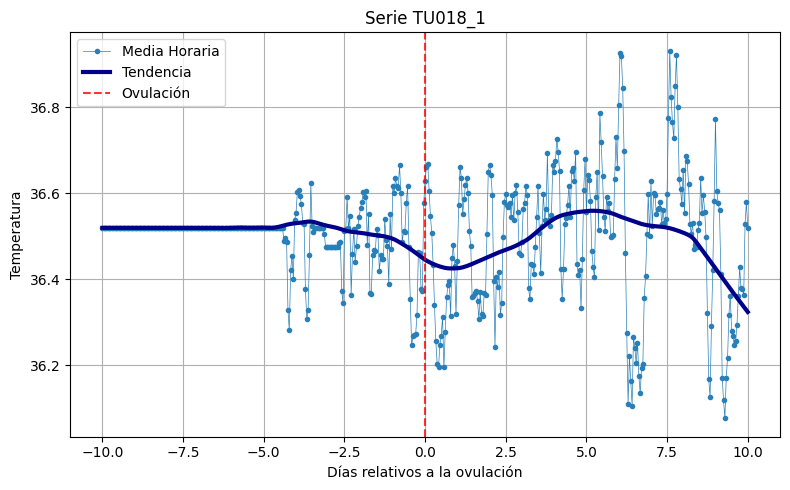

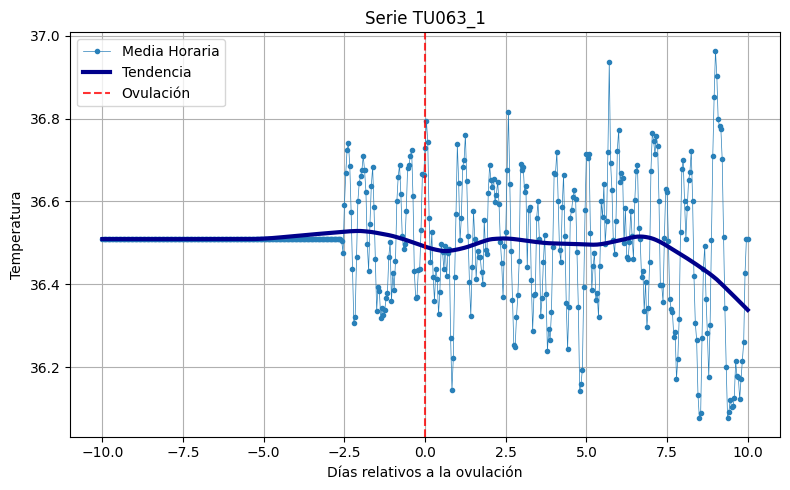

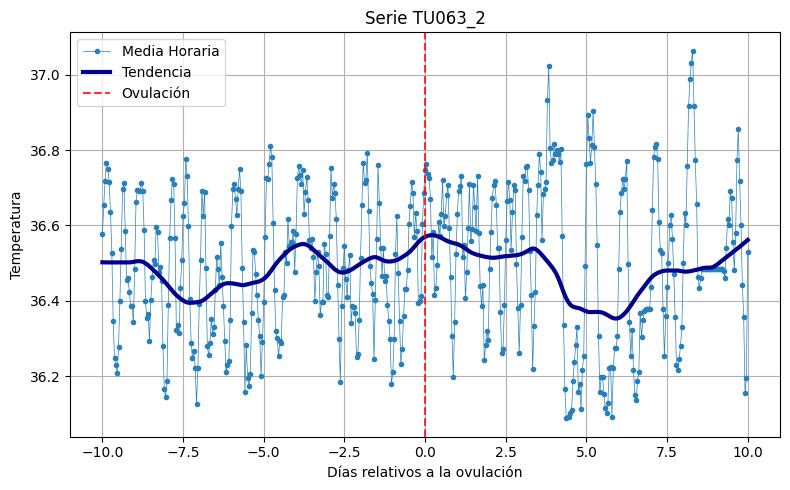

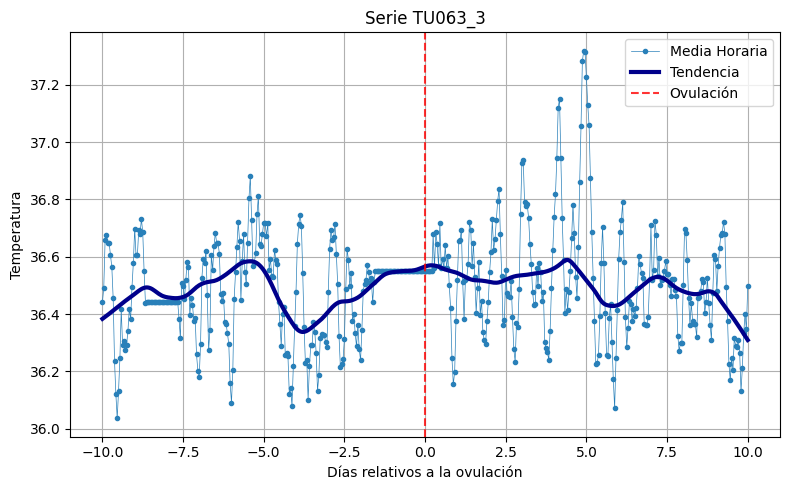

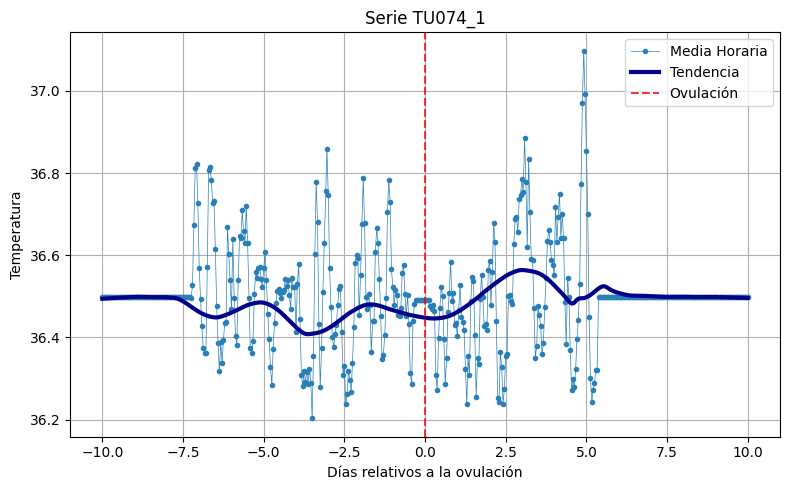

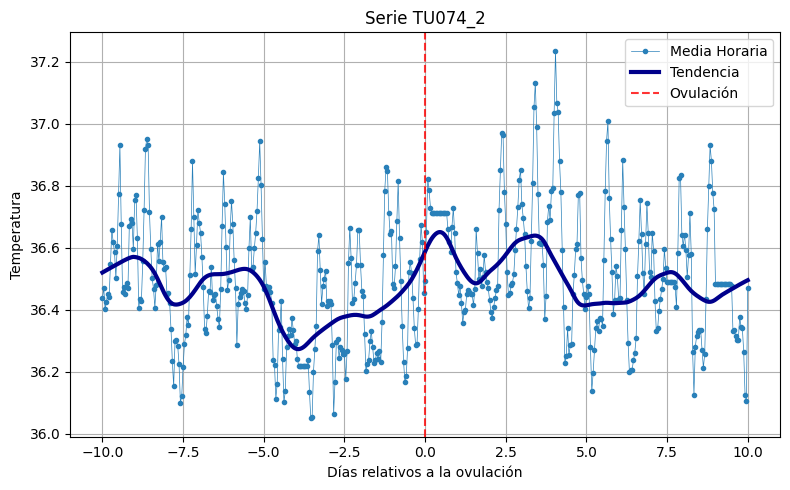

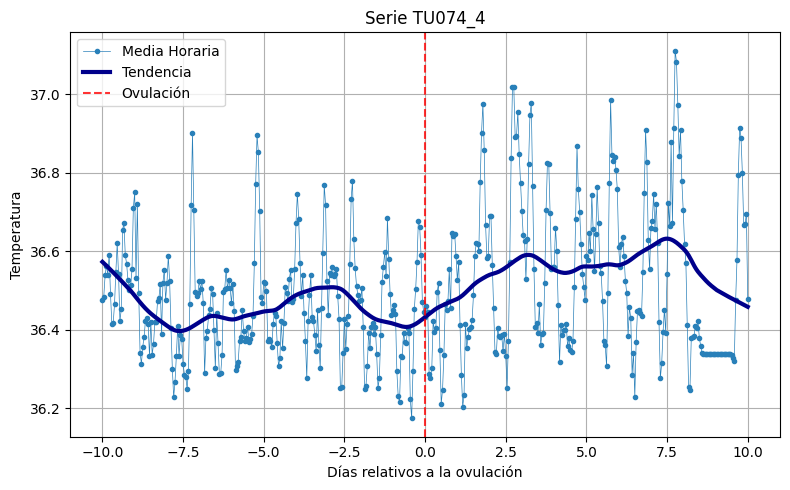

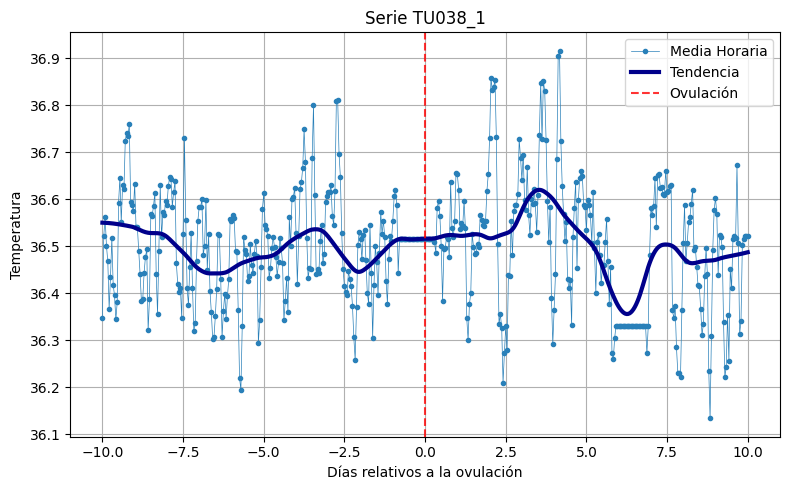

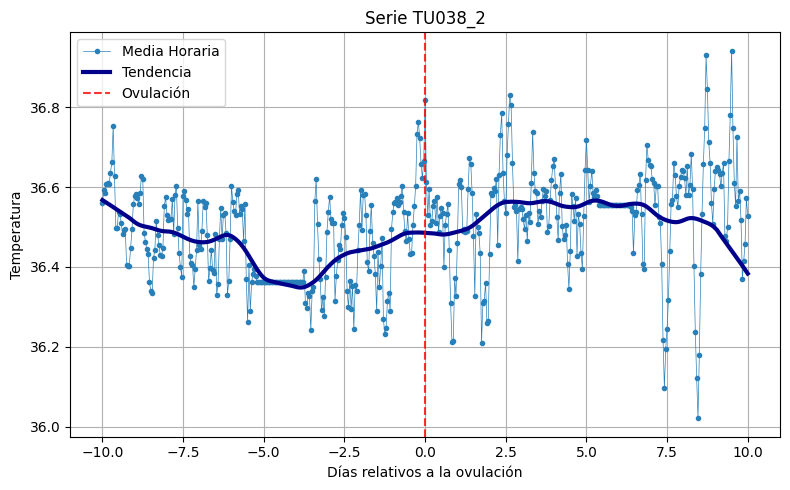

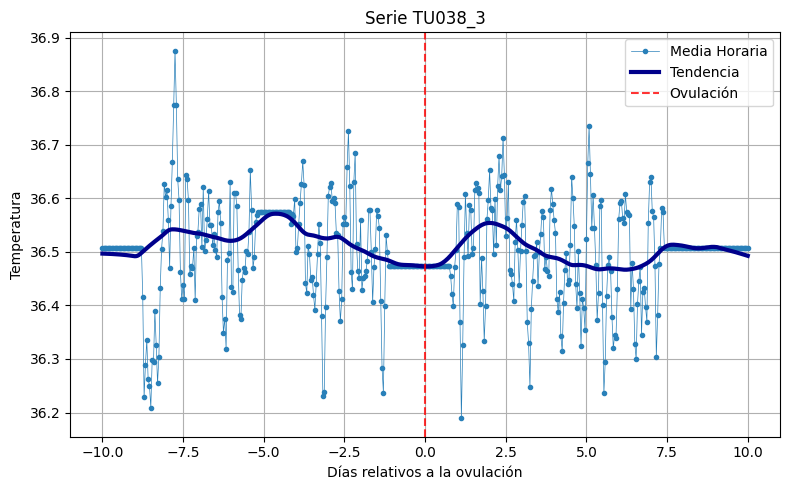

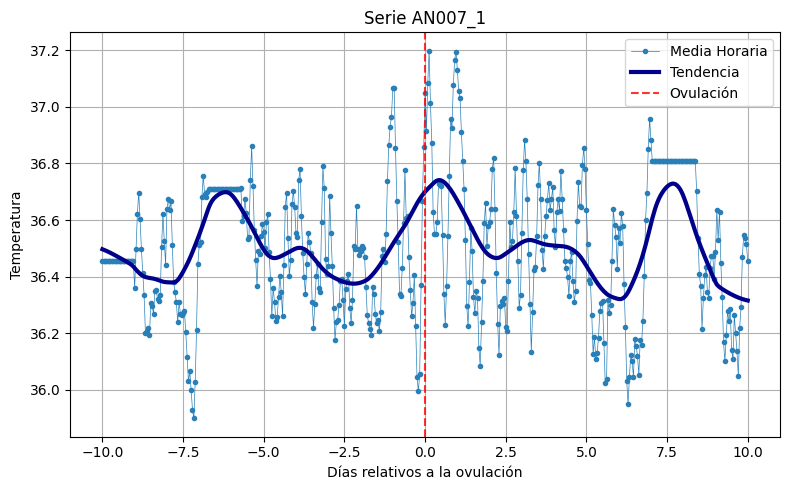

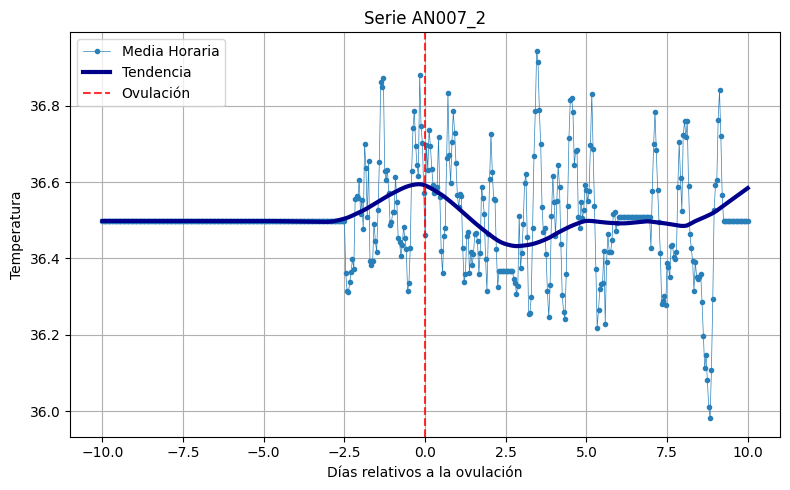

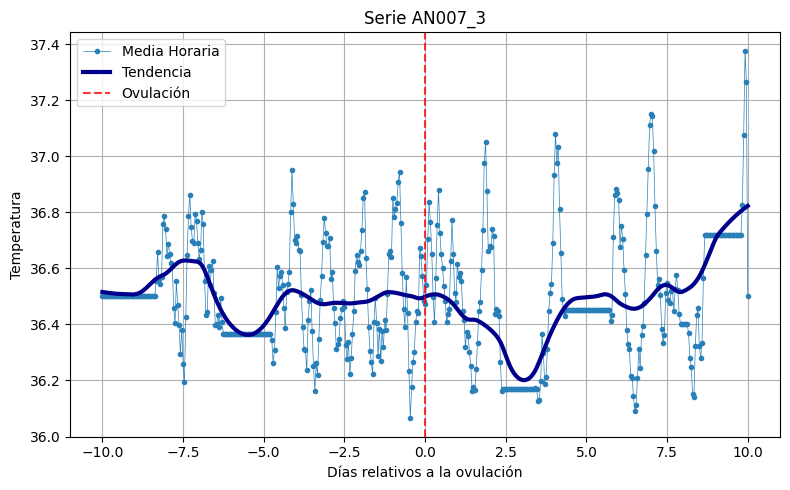

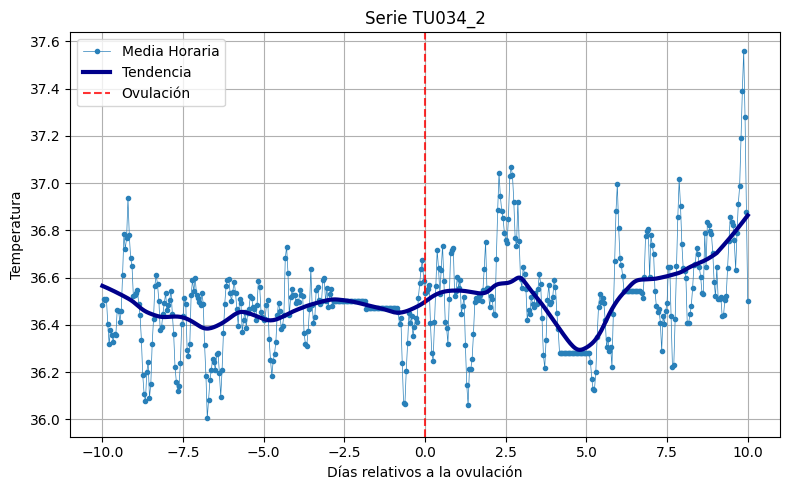

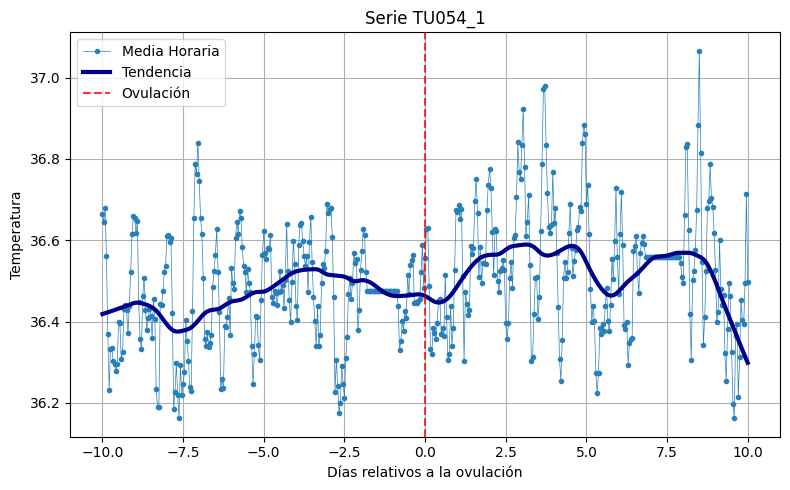

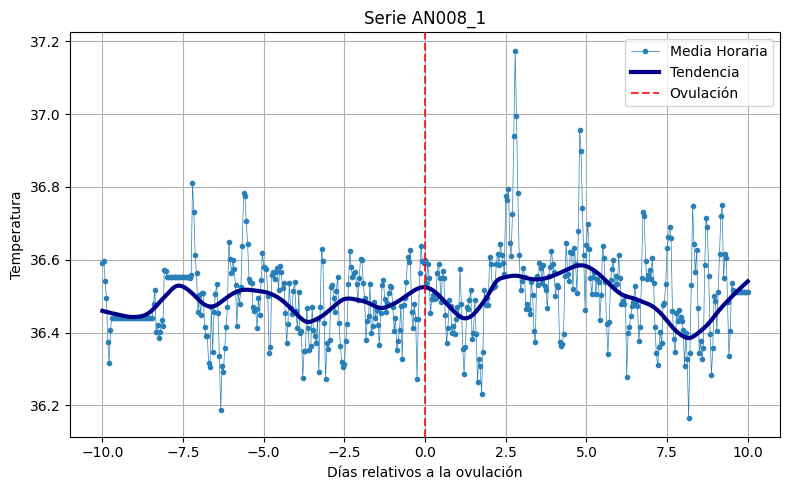

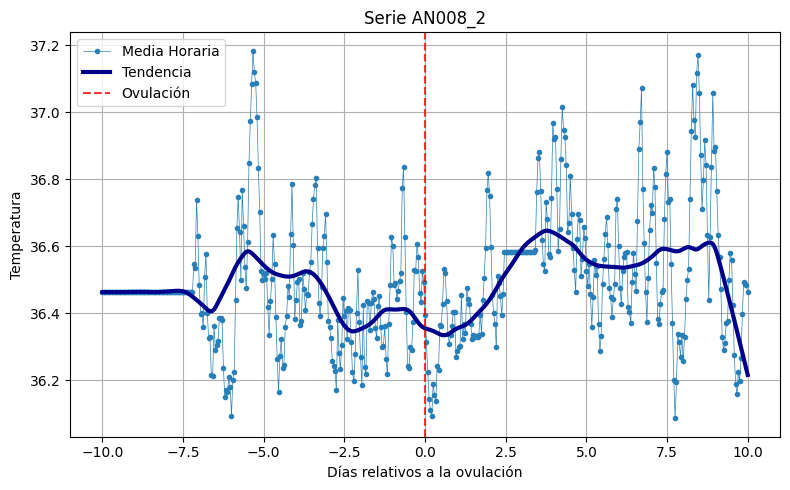

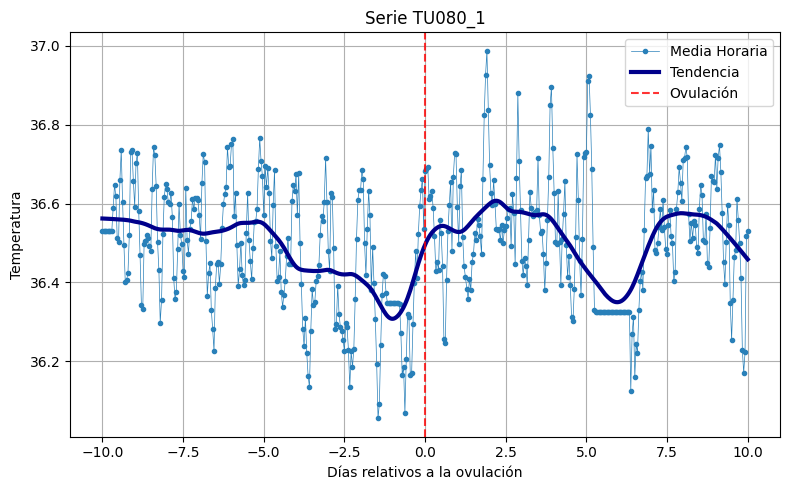

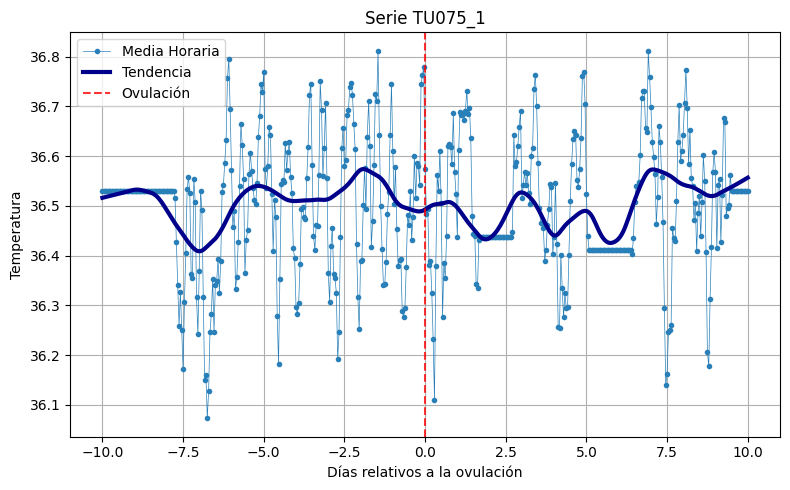

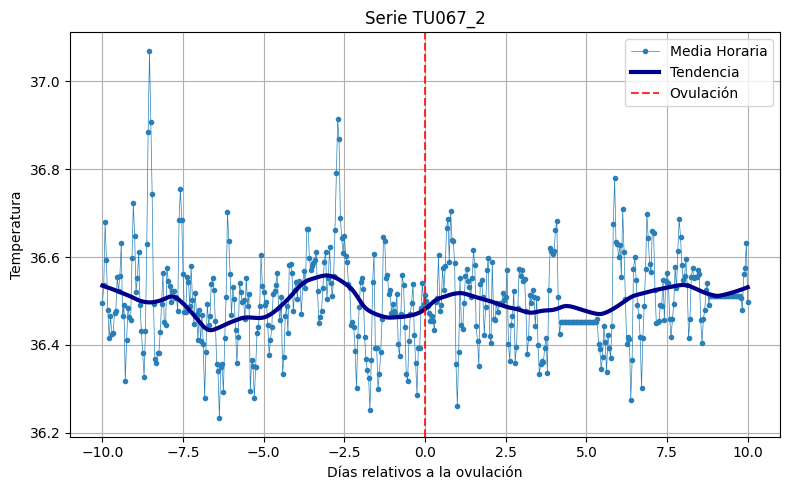

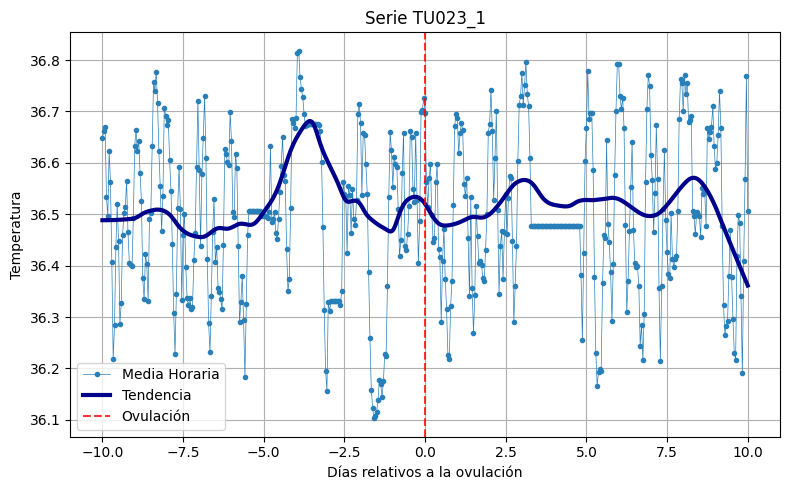

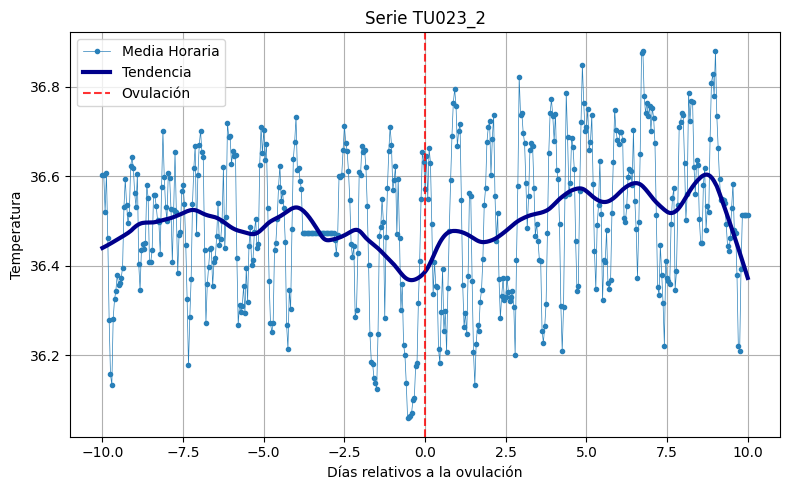

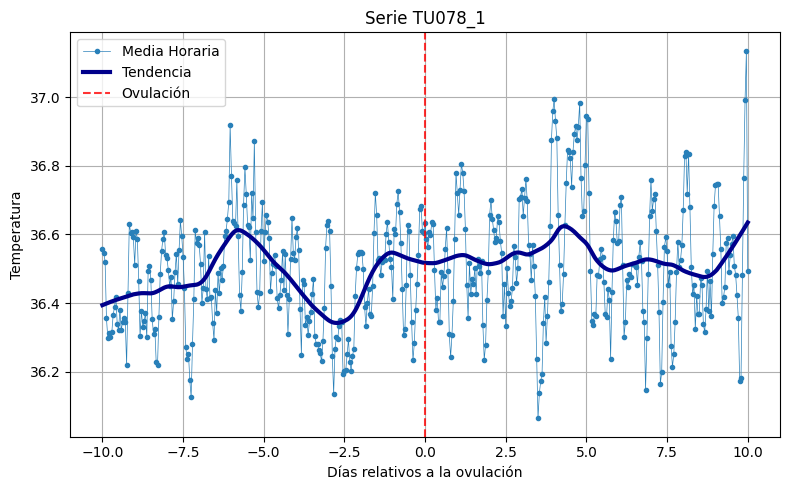

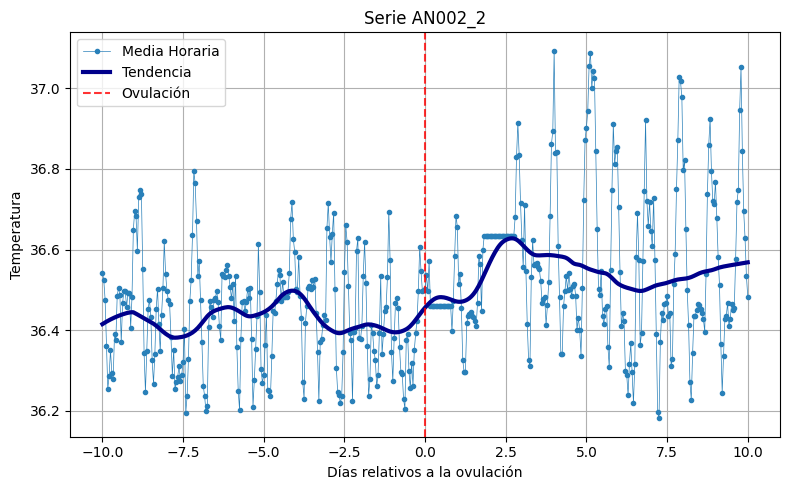

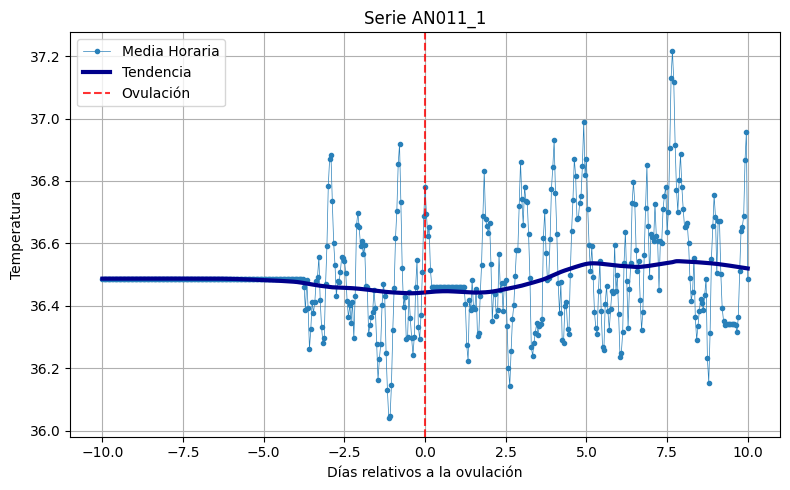

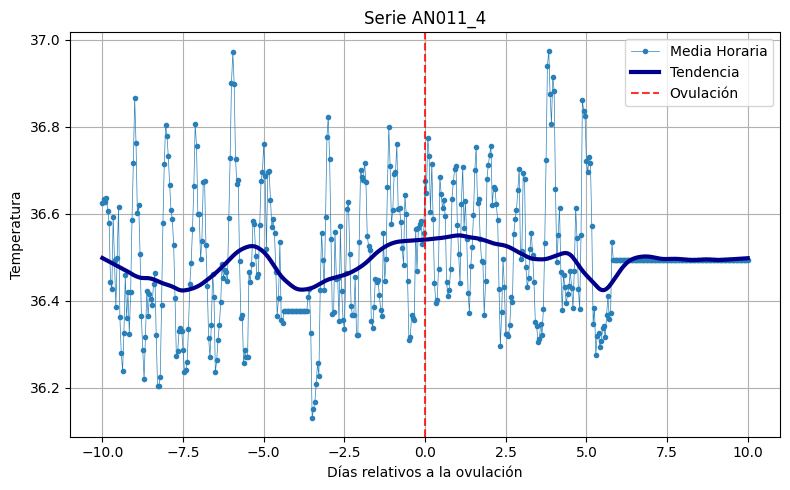

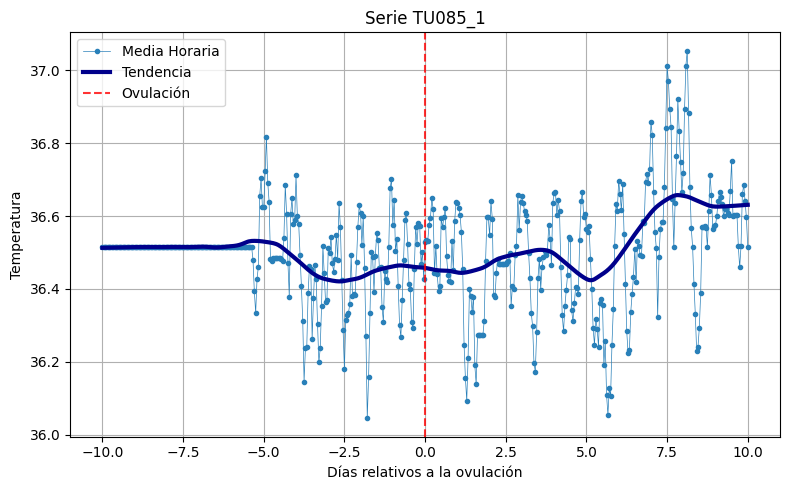

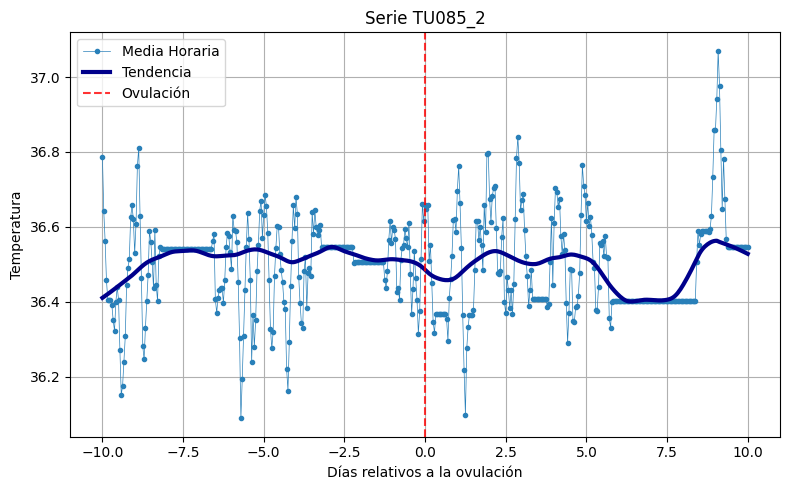

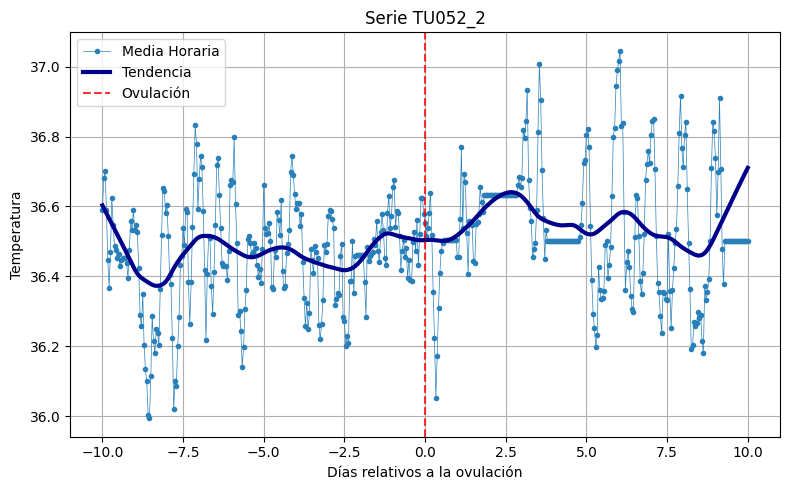

In [42]:
for key, data in list(muestras_tendencia.items()):
    df = data["serie"].copy()
    
    # Calcular días relativos a la ovulación
    df["dias_rel"] = (df["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
    
    plt.figure(figsize=(8, 5))
    plt.plot(df["dias_rel"], df["result"], marker=".", color='#2980B9', linewidth=0.5, label="Media Horaria")
    plt.plot(df["dias_rel"], df["tendencia"], color='darkblue', linewidth=3.0, label="Tendencia")

    # Línea vertical roja en el día 0 (ovulación)
    plt.axvline(x=0, color='red', linestyle='--', label="Ovulación", alpha=0.8)
    
    plt.title(f"Serie {key}")
    plt.xlabel("Días relativos a la ovulación")
    plt.ylabel("Temperatura")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
